# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'search_history/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

sh_topd = search_history.to_pandas()
sh_topd

sh_topd = sh_topd.dropna(subset=['search_query'])

In [2]:
sh_topd['cluster'] = -1

In [3]:
sh_topd

,user_id,timestamp,search_query,action_type_id,widget_name_id,cluster
0,1403825,2024-03-02 19:16:19,колонка алиса,4,23,-1
1,10278224,2024-07-29 12:10:06,батончик,4,23,-1
2,8162261,2024-04-24 06:27:10,hipp combiotic 1,4,23,-1
3,10909038,2024-07-12 04:00:02,бриошь,4,23,-1
4,9148523,2024-04-28 06:58:12,нарезка,4,23,-1
...,...,...,...,...,...,...
78160840,3880979,2024-05-04 18:05:58,томатная паста,4,24,-1
78160841,666694,2024-07-10 08:56:41,пижама женская с шортами,4,24,-1
78160842,2346229,2024-03-06 06:30:44,кровать 120 на 190,4,24,-1
78160843,2455590,2024-06-27 20:52:21,пита,4,24,-1


In [ ]:
#1
milk = ['кефир', 'сметан', 'масло', 'йогурт', 'морожен', 'яйц', 'молок', 'сливк', 'ряжен', 'простокваш', 'пахт', 'сгущенк', 'сыворот', 'exponenta',
        'молоч', 'творо', 'экспонента'
]
#2
sweet = ['конфет', 'мармелад', 'сироп', 'энергетик', 'кекс', 'сахар', 'шоколад', 'батончик', 'варен', 'печень', 'торт', 'чипс', 'лейс', 'lays', 'халв', 
         'зефир', 'пастил', 'пряник', 'леден', 'драже', 'карамел', 'джем', 'мед', 'вафл', 'хлебец', 'семечки', 'киндер', 'хлопья', 'попкорн','сухар',
         'какао', 'слад', 'kinder', 'ролл', 'нори', 'сникерс', 'рождения', 'жвачка', 'bombbar', 'адреналин', 'десерт', 'суш', 
]
#3
cereals = ["греч", "рис", "овсян", "пшен", "перлов", "манк", "кукурузн", "ячнев", "булгур", "киноа", "макарон", "спагетт", "лапш", "вермишел", "фасол", 
           "горох", "нут", "чечевиц", "полб", 'каша', 'доширак', 'геркулес', 'хумус', 'завтрак', 'barilla', 'гранола', 'мюс', 
           
]
#4
veg_and_fruits = ['изюм', 'перец', 'огур', 'помидор', 'шампиньон', 'банан', 'фрукт', 'овощ', 'апельсин', 
                  'томат', 'свекл', 'баклажан', 'мандарин', 'ягод', 'гриб', 'лимон', 'персик', 'цукин', 
                  'яблок', 'груш', 'салат', 'черри', 'морков', 'патиссон', 'картош', 'картоф','капуст',
                  'груша', 'персик', 'апельсин', 'мандарин', 'баклажан', 'лук', 'авокадо', 'клубник', 
                  'зелен', 'кукуруз', 'орех', 'арбуз', 'продукт', 'оливк', 'череш', 'манго', 'шпинат',
                  'голуби', 'виноград', 'брокколи', 'сельдер', 'кабач', 'малин', 'киви', 'редис', 'фисташк', 
                  'лайм', 'маслин', 'семен', 'свеж', 'айсберг', 'азбук', 'арахис', 'fresh', 'финик', 'вишн', 
                  'спарж', 'щавель', 'ананас', 'тыкв', 
]
#5
drink = ['квас', 'сок', 'вод', 'кофе', 'чай', 'лимонад', 'напитк', 'кола', 'пиво', 'напиток', 'лед', 'коктейль'
         'святой', 'источник', 'боржоми', 'морс', 'cola', 'шишкин', 'лес', 'черноголов', 'тоник', 'липтон', 'рычал', 
         'тархун', 'вино', 
]
#6
bread = ['хлеб', 'булк', 'батон', 'багет', 'еда', 'мука', 'пицца', 'лаваш', 'тесто', 'кулич', 'пирожное', 'блин', 'круассан', 'пудинг', 'чиабатта', 
        'сушк', 'пирог', 'пасх', 'рулет', 'выпеч', 'дрожж', 'бургер', 'чизкейк', 
]
#7
cheese = ['сыр', 'брынз', 'моцарел', 'пармезан']
#8
pets = ['корм', 'наполнит', 'лакомств', 'вискас', 'педигри', 'собак', 'кошек', 'кроликов']
#9
meat = ['рыб', 'сосис', 'колбас', 'куриц', 'филе', 'говядин', 'мяс', 'крабов', 'креветк', 'свинин', 'фарш', 'кальмар', 'ветчина', 'пельмени', 'бекон'
        'индейка', 'котлет', 'суп', 'икр', 'груд', 'индейка', 'курин', 'мираторг', 'бекон', 'протеин', 'стейк', 'шашлык', 'тунец', 'форель', 'наггетсы',
        'бедро', 'индилайт', 'нарезк', 'ребр', 'голен', 'консерв', 'лосос', 'фрикадел', 'семг', 'рамен', 'халяль', 'сало', 'сельдь', 'горячая', 'сардель', 
        'тушен', 'онигири', 'свин', 'мидии', 'утк', 
]
#10
household = ['мыл', 'гел', 'паст', 'туалетн', 'крем', 'средств', 'краск', 'стакан', 'волос', 'шампун', 'кондиционер', 'салфетк', 'порошок', 'жидкост', 
             'капсул', 'бумаг', 'бумаж', 'полотен', 'проклад', 'дезодорант', 'батарейки', 'пакет', 'презервативы', 'ватные', 'диски', 'горошек', 'подар',
            'тампоны', 'комаров', 'швабра', 'свечи', 'посуда', 'сковород', 'однораз', 'пищев', 'стол', 'скотч', 'клей', 'книг', 'пласт', 'карт', 'подушк', 
            'отбел', 'чемодан', 'час', 'фольга', 'матрас', 'тетрад', 'доместос', 'удлинитель', 'резинк', 'кукл', 'уголь', 'кружк', 
]

#11
kids = ['подгузник', 'памперс', 'дет', 'соск', 'пюре', 'агуша', 'фрутоняня', 'лего', 'lego', 'игра', 'смес', 'биолакт', 'шарик', 'тема']
#12
clothing = [
    'куртк', 'пальт', 'пуховик', 'ветровк', 'плащ', 'шуб', 'дубленк', 'зимн', 'демисезонн',
    'футболк', 'рубашк', 'блузк', 'водолазк', 'толстовк', 'свитер', 'джемпер', 'кардиган', 'худи',
    'кофт', 'боди', 'топ', 'майк',
    'брюк', 'джинс', 'штан', 'штаны', 'леггинс', 'бридж', 'капри', 'юбк', 'сарафан', 'комбинезон',
    'плать', 'сарафан', 'туник', 'сарафан',
    'трусы', 'трусики', 'бюстгальтер', 'лифчик', 'белье', 'пижам', 'ночн', 'халат', 'комплект',
    'спортивн', 'лосин', 'велосипедк', 'термобелье', 'олимпийк', 'тренировочн', 'спорткостюм',
    'купальник', 'бикини', 'плавк', 'монокини', 'танкини', 'пляжн',
    'шапк', 'кепк', 'шляп', 'панам', 'косынк', 'бандан', 'берет',
    'туфл', 'кроссовк', 'ботинк', 'сапог', 'босоножк', 'сандал', 'угг', 'каблук', 'мокасин', 'лофер',
    'черепик', 'кед', 'балетк', 'сабо', 'дутик',
    'ремен', 'пояс', 'галстук', 'бабочк', 'шарф', 'перчатк', 'варежк', 'зонт', 'очк', 'солнцезащитн',
    'сумк', 'рюкзак', 'клатч', 'кошельк', 'портфель',
    'халат', 'униформа', 'спецовк', 'комбинезон', 'фартук',
    'детск', 'малыш', 'подросток', 'распашонк', 'ползунк', 'пеленк',
    'нос', 'гольф', 'чулк', 'колготк', 'подследник',
    'аксессуар', 'декор', 'украшен', 'бижутери', 'стильн', 'модн', 'брендов', 'одежда', 'шорт', 'легинс'
]
#13
health = [
    # Органы и системы
    'глаз', 'зрен', 'офтальм', 'зрит', 'сетчатк', 'роговиц',
    'сердц', 'карди', 'гипертон', 'давлен', 'пульс', 'аритм',
    'печен', 'гепат', 'желч', 'желуд', 'гастр', 'кишечн', 'панкреат',
    'почк', 'нефр', 'мочевой', 'цистит', 'простат',
    'легк', 'пневм', 'бронх', 'астм', 'кашел', 'насморк', 'горл', 'отит',
    'зуб', 'стомат', 'десн', 'кариес', 'флюс',
    'кож', 'дермат', 'акне', 'псориаз', 'экзем', 'аллерг',
    'нерв', 'неврол', 'головн', 'мигрен', 'инсульт', 'эпилепс',
    'сустав', 'артр', 'остеохондр', 'позвон', 'ревмат', 'артрит',
    'щитовид', 'эндокрин', 'диабет', 'гормон', 'инсулин',
    
    # Препараты и формы выпуска
    'таблетк', 'капсул', 'капл', 'маз', 'крем', 'гел', 'спрей', 'ингалятор',
    'суспенз', 'сироп', 'настойк', 'экстракт', 'назол', 'отинум',
    'антибиот', 'противовирусн', 'антигистаминн', 'анальгин', 'парацетамол',
    'ибупрофен', 'спазмолгон', 'но-шп', 'корвалол', 'валидол',
    'витамин', 'минерал', 'омега', 'магн', 'коллаген', 'пробиот',
    
    # Симптомы и состояния
    'бол', 'воспален', 'отек', 'опухол', 'зуд', 'жжен', 'тошнот', 'рвот',
    'диаре', 'запо', 'метеоризм', 'слабост', 'усталост', 'стресс', 'депресс',
    'бессонн', 'тревожн', 'паническ', 'судорог', 'свист', 'хрип',
    'кровоточивост', 'кров', 'гемоглоб', 'анеми', 'варикоз', 'геморро', 'линзы'
]
#14
sauces = [
    'майонез', 'кетчуп', 'горчиц', 'аджик', 'хрен', 'соус', 'тартар', 'бешамель', 'песто', 'цезар','барбекю', 'чили', 'терияк', 'сальса', 'гуакамоле',
    'сметанн', 'чесночн', 'имбирн', 'устричн', 'рыбн','ткемал', 'кисло-сладк', 'бальзамик', 'вустершир', 'карри','сырн', 'шашлычн', 'гриль', 'паприк', 'чеддер',
    'провансаль', 'брусничн', 'клюквен', 'мятн', 'укропн', 'уксус', 'приправ', 'сода'
]
#15
gadgets = [
    'смартфон', 'iphone', 'андроид', 'телефон', 'кнопочный телефон', 'раскладушка',
    'xiaomi', 'samsung', 'honor', 'huawei', 'nokia', 'realme', 'oppo', 'vivo',
    'планшет', 'ipad', 'электронная книга', 'электронная читалка', 'букридер',
    'ноутбук', 'ультрабук', 'macbook', 'asus', 'lenovo', 'hp', 'dell', 'acer', 'msi',
    'компьютер', 'системный блок', 'моноблок', 'неттоп',
    'клавиатура', 'мышь', 'мышка', 'коврик для мыши', 'трекпад', 'стилус', 'графический планшет',
    'веб-камера', 'микрофон', 'док-станция',
    'процессор', 'видеокарта', 'оперативная память', 'ssd', 'жесткий диск', 'hdd',
    'материнская плата', 'блок питания', 'охлаждение', 'кулер', 'термопаста',
    'наушники', 'airpods', 'гарнитура', 'беспроводные наушники', 'накладные наушники',
    'вкладыши', 'вакуумные', 'колонка', 'динамик', 'bluetooth колонка', 'портативная колонка',
    'микрофон', 'звуковая карта', 'dac', 'усилитель',
    'умные часы', 'smart watch', 'фитнес-браслет', 'умный браслет', 'пульсометр',
    'шагомер', 'gps трекер', 'умное кольцо',
    'чехол', 'защитное стекло', 'плёночка', 'бампер', 'держатель', 'попсокет',
    'кардхолдер', 'кабель', 'зарядка', 'адаптер', 'power bank', 'повербанк',
    'кабель usb', 'кабель type-c', 'lightning', 'переходник', 'разветвитель',
    'подставка', 'держатель для телефона', 'автодержатель',
    'игровая мышь', 'игровая клавиатура', 'джойстик', 'геймпад', 'руль', 'педали',
    'аркадный стик', 'vr', 'виртуальная реальность', 'очки vr', 'гарнитура vr',
    'фотоаппарат', 'зеркалка', 'беззеркалка', 'экшн-камера', 'go pro', 'объектив',
    'штатив', 'монопод', 'стабилизатор', 'гимбал', 'квадрокоптер', 'дрон',
    'умная лампа', 'умная розетка', 'умный дом', 'датчик', 'сенсор', 'камера наблюдения',
    'видеоняня', 'умный замок', 'робот-пылесос', 'умный термостат',
    'принтер', 'сканер', 'ксерокс', 'мфу', 'факс', 'ламинтор', 'брошюровщик',
    'уничтожитель бумаг', 'шредер',
    'электроника', 'гаджет', 'новинка', 'аксессуар', 'комплектующая', 'устройство',
    'беспроводной', 'bluetooth', 'wi-fi', 'usb', 'type-c', 'lightning', 'адаптер', 'вентилятор'
    'паштет', 'айфон', 'увлаж', 'освеж', 'пылесос', 'pro', 'холодильник', 'су вид', 'телевизор', 
    'блендер', 'весы', 
    
]
#18
spices = [
    'перец', 'соль', 'паприк', 'куркум', 'кориандр', 'кардамон', 'имбир', 
    'чеснок', 'лук', 'лавров', 'розмарин', 'тимьян', 'базилик', 'орегано', 
    'шалфей', 'мята', 'укроп', 'петрушк', 'кинз', 'тмин', 'зир', 'кориц', 
    'гвоздик', 'мускат', 'ванил', 'шафран', 'горчиц', 'хрен', 'карри', 
    'прованс', 'фенхел', 'анис', 'кумин', 'чили', 'бадьян', 'кайен',
    'хмел', 'цикор', 'том ям', 
]
#19
woman = ['женск', 'букет']

#20
man = ['мужск']

In [ ]:
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(milk), case=False, na=False), 'cluster'] = 1
print('1 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(sweet), case=False, na=False), 'cluster'] = 2
print('2 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(cereals), case=False, na=False), 'cluster'] = 3
print('3 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(veg_and_fruits), case=False, na=False), 'cluster'] = 4
print('4 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(drink), case=False, na=False), 'cluster'] = 5
print('5 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(bread), case=False, na=False), 'cluster'] = 6
print('6 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(cheese), case=False, na=False), 'cluster'] = 7
print('7 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(pets), case=False, na=False), 'cluster'] = 8
print('8 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(meat), case=False, na=False), 'cluster'] = 9
print('9 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(household), case=False, na=False), 'cluster'] = 10
print('10 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(kids), case=False, na=False), 'cluster'] = 11
print('11 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(clothing), case=False, na=False), 'cluster'] = 12
print('12 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(health), case=False, na=False), 'cluster'] = 13
print('13 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(sauces), case=False, na=False), 'cluster'] = 14
print('14 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(gadgets), case=False, na=False), 'cluster'] = 15
print('15 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('для', case=False, na=False), 'cluster'] = 16
print('16 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('цвет', case=False, na=False), 'cluster'] = 17
print('17 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(spices), case=False, na=False), 'cluster'] = 18
print('18 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(woman), case=False, na=False), 'cluster'] = 19
print('19 finished')
sh_topd.loc[sh_topd['search_query'].str.contains('|'.join(man), case=False, na=False), 'cluster'] = 20
print('20 finished')


remaining_negatives = (sh_topd['cluster'] == -1).sum()
print(f"Осталось строк с меткой -1: {remaining_negatives}")

1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
12 finished
13 finished
14 finished
15 finished
16 finished
17 finished
18 finished
Осталось строк с меткой -1: 23932935


In [1]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2


In [2]:
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

In [3]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

In [4]:
val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

In [5]:
val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [6]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [8]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5144\276488151.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [9]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()

num_cols = ['num_products_click', 'sum_discount_price_click', 'max_discount_price_click', 'days_since_last_click', 'days_since_first_click', 
    'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite', 'days_since_last_favorite', 
    'days_since_first_favorite', 'num_products_order', 'sum_discount_price_order', 'max_discount_price_order', 'days_since_last_order', 
    'days_since_first_order', 'num_products_to_cart', 'sum_discount_price_to_cart', 'max_discount_price_to_cart', 'days_since_last_to_cart', 
    'days_since_first_to_cart']

In [10]:
from local_utils import *

df_pd = add_polynomial_features_pd(df_pd, num_cols, degree=3)

df_pd = df_pd[df_pd['user_id'] != 2346229]

tr, val = get_split(df_pd, val_size=0.3)

cols = [
    # Существующие столбцы
    'num_products_click', 
    'sum_discount_price_click', 'max_discount_price_click',
    'days_since_last_click', 'days_since_first_click',
    'num_products_favorite', 'sum_discount_price_favorite',
    'max_discount_price_favorite', 'days_since_last_favorite',
    'days_since_first_favorite', 'num_products_order',
    'sum_discount_price_order', 'max_discount_price_order',
    'days_since_last_order', 'days_since_first_order',
    'num_products_to_cart', 'sum_discount_price_to_cart',
    'max_discount_price_to_cart', 'days_since_last_to_cart',
    'days_since_first_to_cart', 'num_search', 'days_since_last_search',
    'days_since_first_search', 
    'main_search_cluster', 'num_search_clusters',
    
    # Новые столбцы из анализа поиска
    'unique_search_queries',               # Количество уникальных поисковых запросов
    'num_search_last_month',               # Поисков за последний месяц
    'num_search_last_week',                # Поисков за последнюю неделю
    'search_daily_rate',                   # Среднедневная частота поисков
    'recent_search_cluster',               # Последний доминирующий кластер
    'search_cluster_concentration',        # Концентрация интересов
    'search_cluster_switches',             # Переключения между кластерами
    'search_cluster_stability',            # Стабильность кластеров
    'main_search_cluster_time_ratio',      # Время в основном кластере
    'search_mean_cluster_switch_days',     # Среднее время между сменами кластеров
    'search_mean_query_len',               # Средняя длина запроса
    'search_main_cluster_query_len_diff',  # Разница длины запросов
]

params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)


c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:632: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f'{feat1}_x_{feat2}^2'] = result_df[feat1] * result_df[feat2]**2
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:627: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[f'{feat1}_x_{feat2}'] = result_df[feat1] * result_df[feat2]
c:\Users\Admin\Desktop\AIM 2сем\ML2\hw2\local_utils.py:631: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 453295, number of negative: 859173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7133
[LightGBM] [Info] Number of data points in the train set: 1312468, number of used features: 37
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345376 -> initscore=-0.639427
[LightGBM] [Info] Start training from score -0.639427
Training until validation scores don't improve for 60 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:

feature_importance: [1877  536  372  477  328  378   48  274   91  245 1151 1234  596 1498
 1804 1194 1060  516  572  847  410  285  365  698  344  122  510   84
  483  151   64  251  637    0  123  672  163] 



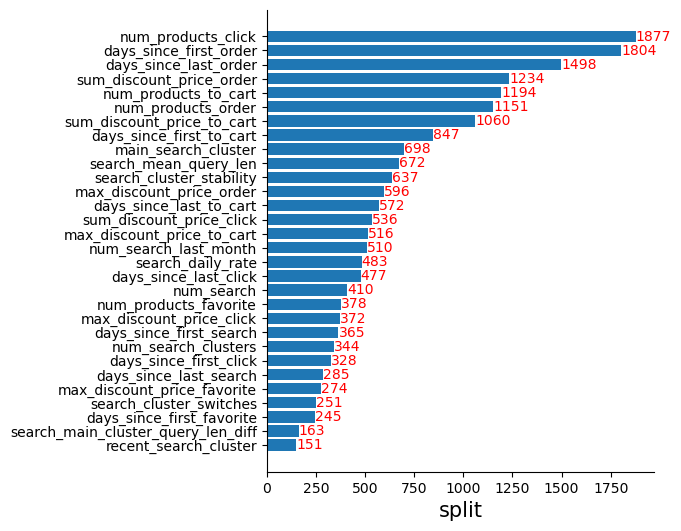

In [11]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [12]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_5144\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [13]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5144\555555092.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [14]:
df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()

In [ ]:
from local_utils import *

df_pd = add_polynomial_features_pd(df_pd, num_cols, degree=3)

df_pd['predict'] = model.predict_proba(df_pd[cols])[:, 1]

In [17]:
df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.160732
1,9852,0.774060
2,10206,0.223584
3,11317,0.229717
4,13289,0.571413
...,...,...
2068419,11157283,0.195087
2068420,11160395,0.143202
2068421,11165052,0.612722
2068422,11168218,0.479801


In [18]:
df_pd[['user_id', 'predict']].to_csv('try_to_repeat_score.csv', index=False)